# Food UK - Logistic Regression

- _Author_: Lucas Gonzalez Santa Cruz
- _Workshop_: Data Science Intensive, Springboard.com
- _Date_: 27 September 2016

# tl;dr

_In the UK, since 1974, several thousands of families are selected each year (different families each year). Data is collected about **each family** (about 50 variables: place, number of members of different ages, socioeconomic variables), and about **what each family buys over one week** (3 pints of skimmed milk, 2 pounds sterling; etc). Food items ("brown bread") are categorised into food groups ("breads"). For each food item, 47 **nutrients** are known (calories, vitamin D, etc)._

_I'm interested in food generally, but for this project I will only:_
- _define a score of "shopping-cart goodness" (more fruit+vegs than junk food)_
- _look at how some family variables (income, location, etc) predict a "good cart"_

# Table of Contents
* [Motivation and goals](#Motivation-and-goals)
* [Data sources and datasets](#Data-sources-and-datasets)
* [Data wrangling](#Data-wrangling)
    * [Getting the files](#Getting-the-files)
    * [Arranging the food groups](#Arranging-the-food-groups)
    * [Putting it all together](#Putting-it-all-together)
* [Modeling](#Modeling)
    * [Score](#Score)
    * [Categorisation](#Categorisation)
    * [Logistic regression](#Logistic-regression)
    * [Some other tool](#Some-other-tool)
    * [Other tools](#Other-tools)
* [Discussion](#Discussion)
    * [Summary of findings](#Summary-of-findings)
    * [Limitations](#Limitations)
    * [Further work](#Further-work)
        * [Nutrients](#Nutrients)
        * [Food production](#Food-production)
        * [Data science tools](#Data-science-tools)

# Motivation and goals

Food is interesting for many inter-related reasons: food security (poverty, climate change), nutritional health (blue zones), ecological reasons (edible forests), economic developement (jobs), data and automation (mapping images of fields to help growers).

Here I'll start using one particular dataset with the intention of learning to use some ML procedures.

Specifically, I will look at what food UK families buy, and try to predict the healthiness of their shopping from their demographic variables.

# Data source and datasets

UK families (a different sample each year for many years), have been asked what food they buy for a week.

Data between 1974-2000 is open data:
* Available at http://britains-diet.labs.theodi.org
* Datasets:
    * Households: a file with a line per household, and for each of them 53 variables: number of female adults, male adults and children; income; location; etc. Also, many files translating codes to literals: 11=Scotland, 1=household owner is female, etc.
    * Purchases: a file with a line per food item bought: a certain household bought, over the course of a week, 6 loaves of brown bread (money paid), 3 pints of skimmed milk (money paid), etc.
    * Food groups: several files that put the 300+ food items ("milk", "cheese") into 20+ food groups ("milky products").
    * Nutrients: for each food item (and even for 4 "seasons" each year) there's information about 47 nutrients (calories, vitamin D, etc).

(Data since 2001 is published only in summarised form. We won't be using it here.)

# Data wrangling

* We want one line per household.
* Household variables: household identifier, year, and the other 50+ variables.
* Also for each household: how much of each food they bought.
* Finally, also for each household: a score of "good food", say dividing the amount of fruit per the amount of chocolate (or the other way round, depending who you ask!), and then a categorisation of that score, say stating that a score higher than 5 is good.

In [1]:
# ===== IMPORTs, SETTINGS AND FUNCTIONS

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm

import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

import numpy as np
import scipy as sp

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]

from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, \
                alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, \
                     ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, \
                           cdiscrete=cdiscrete, psize=psize, alpha=alpha, predicted=True) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax 

In [2]:
# =============================
# ===== GETTING THE FILES =====
# =============================

#http://data.defra.gov.uk/Food/NationalFoodSurvey/NFSopen_2000.zip (etc for all years)
#http://data.defra.gov.uk/Food/NationalFoodSurvey/NFSopen_Reference.zip
data = 'data/'
data2000 = 'data/NFSopen_2000/'
dataRefe = 'data/NFSopen_Reference/'

In [3]:
# ========================================
# ===== FOOD CODES, UNITS AND GROUPS =====
# ========================================

#315 detailed "minor" foodcodes ...
df_min_maj = pd.DataFrame.from_csv(dataRefe+'Ref_ Minor and major foods.txt', sep='\t', index_col=None)
df_min_maj.columns=['minor', 'minor_text', 'major']

#... then aggregated into 184 "major" groups.
df_maj_text = pd.DataFrame.from_csv(dataRefe+'Ref_ Major food codes.txt', sep='\t', index_col=None)
df_maj_text.columns=['major', 'major_text']

#Each "foodcode" (all 315 of them) was described with one of 7 "units": pints, ounces, etc.
df_min_units = pd.DataFrame.from_csv(dataRefe+'Ref_MINFD_Minor_food_codes.txt', sep='\t', index_col=None)
df_min_units.columns=['minor','minor_text','units']
df_min_units.drop(['minor_text'], inplace=True, axis=1) #to avoid duplicate later

#24 more aggregated "groups" were defined, and the 183 previous "detailed groups" were mapped to these 24.
df_grp_text = pd.DataFrame.from_csv(dataRefe+'Ref_ food groups (standard).txt', sep='\t', index_col=None)
df_grp_text.columns=['group','group_text']

#A "mapping" file with 596 rows ...
df_mapping = pd.DataFrame.from_csv(dataRefe+'Ref_ Major-food group mapping.txt', sep='\t', index_col=None)
df_mapping.columns=['major','group']

#... had 92 groups, and those 24 had to be selected.
group24 = [4006, 9017, 22023, 31041, 46094, 100127, 129129, 135148, 150154, 155161, 162171, 172183, \
           184208, 210231, 233248, 251263, 264264, 267277, 281301, 304313, 314339, 340344, 350354, 380389]
df_maj_group = df_mapping[df_mapping['group'].isin(group24) == True] #shape 183x2

# ===== df_groups 315 groups x 6 fields: minor, minor_text, major, major_text, group, group_text
df = pd.merge(df_min_maj, df_maj_text, how='left', on='major')
df = pd.merge(df, df_maj_group, how='left', on='major')
df = pd.merge(df, df_grp_text, how='left', on='group')
df_groups = df

In [4]:
print "Here's the number of food codes per group:"
df.groupby('group_text').minor.nunique()

Here's the number of food codes per group:


group_text
ALCOHOLIC DRINKS                            10
ALL BREAD                                   22
ALL CARCASE MEAT                            17
ALL FATS                                    17
ALL FISH                                    19
ALL NON-CARCASE MEAT AND MEAT PRODUCTS      50
ALL OTHER FOODS                             23
ALL PROCESSED VEGETABLES                    22
BEVERAGES                                    6
BISCUITS, CAKES, BUNS, CRISPBREADS           7
CEREALS, EXCL. BREAD,BUNS,CAKES,BISCUITS    33
CONFECTIONERY                                6
EGGS                                         1
FLOUR                                        1
FRESH FRUIT                                 10
FRESH GREEN VEGETABLES                       7
FRUIT & FRUIT PRODS. NOT FRESH               6
LIQUID WHOLEMILK, INC SCHOOL & WELFARE       6
OTHER FRESH VEGETABLES                       8
OTHER MILK & CREAM                          14
POTATOES                                    12
SO

In [5]:
df = df_groups
df = pd.merge(df, df_min_units, how='left', on='minor')
list_of_groups = list(df_grp_text['group_text'].sort_values())
for g in list_of_groups:
    this_group = g
    dfg = df[df.group_text == this_group]
    list_of_units = dfg['units'].tolist()
    first_unit = list_of_units[0]
    all_units_are_the_same = "yes"
    for u in list_of_units:
            this_unit = u
            if this_unit != first_unit: all_units_are_the_same = "no"
    if all_units_are_the_same == "no":
        print this_group, "have different units:", list_of_units
        #print dfg.minor_text.unique()
        #print dfg[['minor_text', 'units']]
    else:
        print this_group, "are all", this_unit
        #print dfg.minor_text.unique()

ALCOHOLIC DRINKS have different units: ['cl', 'cl', 'cl', 'cl', 'cl', 'cl', 'cl', 'cl', 'cl', 'ml']
ALL BREAD are all oz
ALL CARCASE MEAT are all oz
ALL FATS have different units: ['oz', 'oz', 'oz', 'oz', 'oz', 'oz', 'oz', 'floz', 'floz', 'floz', 'oz', 'oz', 'oz', 'oz', 'oz', 'oz', 'oz']
ALL FISH are all oz
ALL NON-CARCASE MEAT AND MEAT PRODUCTS are all oz
ALL OTHER FOODS have different units: ['floz', 'oz', 'oz', 'oz', 'oz', 'oz', 'oz', 'oz', 'oz', 'oz', 'oz', 'oz', 'oz', 'floz', 'floz', 'floz', 'floz', 'floz', 'floz', 'oz', 'oz', 'oz', 'oz']
ALL PROCESSED VEGETABLES have different units: ['oz', 'oz', 'oz', 'oz', 'oz', 'oz', 'oz', 'oz', 'floz', 'oz', 'oz', 'oz', 'oz', 'oz', 'oz', 'oz', 'oz', 'oz', 'oz', 'oz', 'oz', 'oz']
BEVERAGES have different units: ['oz', 'oz', 'oz', 'floz', 'oz', 'oz']
BISCUITS, CAKES, BUNS, CRISPBREADS are all oz
CEREALS, EXCL. BREAD,BUNS,CAKES,BISCUITS are all oz
CONFECTIONERY are all g
EGGS are all egg
FLOUR are all oz
FRESH FRUIT are all oz
FRESH GREEN VEGETA

In [6]:
# =============================================================
# ===== HOW TO SELECT FOOD GROUPS AND SPECIFIC FOOD ITEMS =====
# =============================================================

df = df_groups #but could be df_diary14 below!
df = df[df.group_text == 'ALL BREAD']
##print df #shows that some kinds of bread where only coded until 1992, etc
print df.minor_text.unique()

print "\nwhat are the units for quantity of the different kinds of bread?"
df = df_groups
df = pd.merge(df, df_min_units, how='left', on='minor')
df = df[df.group_text == 'ALL BREAD']
df = df[['minor_text', 'units']]
print df

['BREAD  WHITE  LARGE  UNSLICED' 'BREAD WHITE UNSLICED STANDARD'
 'BREAD  WHITE  LARGE  SLICED' 'BREAD WHITE SLICED STANDARD'
 'BREAD  WHITE  SMALL  UNSLICED' 'BREAD  WHITE  SMALL  SLICED'
 'BREAD  BROWN' 'BREAD  WHOLEWHEAT  &  WHOLEMEAL'
 'BREAD WHITE SLICED PREMIUM' 'BREAD WHITE SLICED SOFT GRAIN'
 'BREAD BROWN SLICED' 'BREAD WHOLEMEAL SLICED' 'BREAD BROWN UNSLICED'
 'BREAD WHOLEMEAL UNSLICED' 'BREAD  OTHER' 'ROLLS  (EXCL STARCH-REDUCED)'
 'MALT BREAD AND FRUIT BREAD' 'VIENNA BREAD AND FRENCH BREAD'
 'STARCH REDUCED BREAD AND ROLLS' 'OTHER BREAD' 'SANDWICHES']

what are the units for quantity of the different kinds of bread?
                          minor_text units
202    BREAD  WHITE  LARGE  UNSLICED    oz
203    BREAD WHITE UNSLICED STANDARD    oz
204      BREAD  WHITE  LARGE  SLICED    oz
205      BREAD WHITE SLICED STANDARD    oz
206    BREAD  WHITE  SMALL  UNSLICED    oz
207      BREAD  WHITE  SMALL  SLICED    oz
208                     BREAD  BROWN    oz
209  BREAD  WHOLEWHEA

In [7]:
# =========================
# ===== DIARY ENTRIES =====
# =========================

df_purc1995 = pd.DataFrame.from_csv(data+'1995 diary data.txt', sep='\t', index_col=None)
df_purc1995['survyear'] = '1995'
df_purc1996 = pd.DataFrame.from_csv(data+'1996 diary data.txt', sep='\t', index_col=None)
df_purc1996['survyear'] = '1996'
df_purc1997 = pd.DataFrame.from_csv(data+'1997 diary data.txt', sep='\t', index_col=None)
df_purc1997['survyear'] = '1997'
df_purc1998 = pd.DataFrame.from_csv(data+'1998 diary data.txt', sep='\t', index_col=None)
df_purc1998['survyear'] = '1998'
df_purc1999 = pd.DataFrame.from_csv(data+'1999 diary data.txt', sep='\t', index_col=None)
df_purc1999['survyear'] = '1999'
df_purc2000 = pd.DataFrame.from_csv(data+'2000 diary data.txt', sep='\t', index_col=None)
df_purc2000['survyear'] = '2000'
list_of_years = [df_purc1995, df_purc1996, df_purc1997, df_purc1998, df_purc1999, df_purc2000]
df = pd.concat(list_of_years)
df.columns=['hhno', 'fooditem', 'logday', 'purchasevalue', 'minor', 'quantity', 'purchasefree', 'survyear']
df_diary8 = df

# ===== idem + adding "_text", "group" and "unit" variables
df = pd.merge(df_diary8, df_min_maj, how='left', on='minor')
df = pd.merge(df, df_min_units, how='left', on='minor')
df = pd.merge(df, df_maj_text, how='left', on='major')
df = pd.merge(df, df_maj_group, how='left', on='major')
df = pd.merge(df, df_grp_text, how='left', on='group')
print "variables:", len(df.columns), list(df.columns.values)

# ===== DIARY WITH 14, 10 or 6 VARIABLES
df_diary14 = df
df_diary10 = df[['survyear', 'hhno', 'quantity', 'units', 'minor_text', \
                 'group_text', 'minor', 'major', 'major_text', 'group']]
df_diary6  = df[['survyear', 'hhno', 'minor_text', 'quantity', 'units', 'group_text']]
print "DIARY ENTRIES: in 1995-2000, {0:4} families bought {1:6} items, {2:3} foods in {3:2} groups.".\
    format(len(df.hhno.unique()), len(df), len(df.minor_text.unique()), len(df.group_text.unique()))

variables: 14 ['hhno', 'fooditem', 'logday', 'purchasevalue', 'minor', 'quantity', 'purchasefree', 'survyear', 'minor_text', 'major', 'units', 'major_text', 'group', 'group_text']
DIARY ENTRIES: in 1995-2000, 42960 families bought 1581381 items, 243 foods in 24 groups.


In [8]:
# ==================================================
# ===== SELECTING FOOD GROUPS/ITEMS FROM DIARY =====
# ==================================================

df = df_diary14
df = df[df.group_text == 'ALL BREAD']
print "how many purchases of the different kinds of bread?"
print pd.value_counts(df['minor_text'].values, sort=True)
#print df[['hhno', 'minor_text']].groupby('minor_text').count()

print "\nhow much quantity purchased of the different kinds of bread?"
print df.groupby('minor_text').quantity.sum().sort_values(ascending = False)

#pd.value_counts(dfb['minor_text'].values, sort=True)

#pd.crosstab(dfb.minor_text, dfb.survyear, values = dfb.quantity, aggfunc=np.sum)

#dfb.minor_text.value_counts().sort_values().plot(kind='barh')
##pd.value_counts(dfb['minor_text'].values).plot(kind='barh') #also works

##this dataset only has one numeric variable
#dfs = dfb.apply(pd.to_numeric, errors='ignore')
#dfs.plot(x='quantity', y='survyear', kind='scatter')

#dfc = dfb[(dfb.minor_text == "BREAD WHITE SLICED STANDARD") | (dfb.minor_text == "BREAD WHITE SLICED PREMIUM")]
#pd.crosstab(dfc.survyear, dfc.minor_text, values = dfc.quantity, aggfunc=np.sum).plot(kind='line')
#plt.title('Comparing the tendencies of 2 types of bread')
#plt.ylabel('Survey year')

how many purchases of the different kinds of bread?
BREAD WHITE SLICED STANDARD       29964
ROLLS  (EXCL STARCH-REDUCED)      18740
BREAD WHITE SLICED PREMIUM        11394
BREAD WHOLEMEAL SLICED             8934
BREAD WHITE UNSLICED STANDARD      8870
BREAD BROWN SLICED                 7813
OTHER BREAD                        7711
VIENNA BREAD AND FRENCH BREAD      7270
BREAD WHOLEMEAL UNSLICED           3382
SANDWICHES                         2882
BREAD BROWN UNSLICED               2607
MALT BREAD AND FRUIT BREAD         2224
BREAD WHITE SLICED SOFT GRAIN      1492
STARCH REDUCED BREAD AND ROLLS     1350
dtype: int64

how much quantity purchased of the different kinds of bread?
minor_text
BREAD WHITE SLICED STANDARD       1057811.10
BREAD WHITE SLICED PREMIUM         384282.00
BREAD WHOLEMEAL SLICED             273085.70
ROLLS  (EXCL STARCH-REDUCED)       263994.77
BREAD WHITE UNSLICED STANDARD      232218.54
BREAD BROWN SLICED                 217361.57
VIENNA BREAD AND FRENCH BREAD   

In [9]:
# ======================
# ===== HOUSEHOLDS =====
# ======================

df_hous1995 = pd.DataFrame.from_csv(data+'1995 household data.txt', sep='\t', index_col=None)
df_hous1995['survyear'] = '1995'
df_hous1996 = pd.DataFrame.from_csv(data+'1996 household data.txt', sep='\t', index_col=None)
df_hous1996['survyear'] = '1996'
df_hous1997 = pd.DataFrame.from_csv(data+'1997 household data.txt', sep='\t', index_col=None)
df_hous1997['survyear'] = '1997'
df_hous1998 = pd.DataFrame.from_csv(data+'1998 household data.txt', sep='\t', index_col=None)
df_hous1998['survyear'] = '1998'
df_hous1999 = pd.DataFrame.from_csv(data+'1999 household data.txt', sep='\t', index_col=None)
df_hous1999['survyear'] = '1999'
df_hous2000 = pd.DataFrame.from_csv(data+'2000 household data.txt', sep='\t', index_col=None)
df_hous2000['survyear'] = '2000'

list_of_years = [df_hous1995, df_hous1996, df_hous1997, df_hous1998, df_hous1999, df_hous2000]
df = pd.concat(list_of_years)
print "households:", len(df)
print "variables:", len(df.columns), list(df.columns.values)
df_households = df

households: 43624
variables: 54 ['hhno', 'gormet2', 'reg', 'lad', 'styr', 'stmth', 'mic', 'frez', 'owndw', 'memhh', 'schmilk', 'incgp', 'occhoh', 'sochoh', 'dacthoh', 'Finc_decile_by_members_of_hh', 'finctp', 'pernohoh', 'pernohw', 'agehoh_banded', 'agehw_banded', 'adltm', 'adltf', 'child', 'oaps', 'adltgt64', 'stqtr', 'country', 'gor', 'agemdk_banded', 'incgpa', 'hhcomp', 'hhcompa', 'hcxigs', 'dat1rec', 'doormilk', 'frij', 'earners', 'occxhoh', 'socxhoh', 'dactxhoh', 'szwkest', 'empst', 'wkdy1rec', 'vegind', 'gornw', 'pernxhoh', 'jobsthoh', 'incgp745', 'withjob', 'landlord', 'furnish', 'benefits', 'survyear']


In [10]:
# ===== 53 VARIABLES FOR EACH HOUSEHOLD (+ survyear):
df_house_fields = pd.DataFrame.from_csv(dataRefe+'house-fields.txt', sep='\t', index_col=None)
df_house_fields.columns=['table', 'field', 'field_text', 'type1', 'size', 'type2', 'lookup', 'notes']
df_house_fields = df_house_fields[['field', 'field_text', 'lookup', 'notes']]

#Most of the 53 fields have files detailing their values:
#=== government office region metropolitan county = 27 x (code, text)
#df_gormet2 = pd.DataFrame.from_csv(dataRefe+'DCV_ GORMET2.txt', sep='\t', index_col=None)
#=== standard statistical region = 11 x (code, text); Scotland = 1
#df_reg = pd.DataFrame.from_csv(dataRefe+'DCV_ Region.txt', sep='\t', index_col=None)
#=== local authority district = 457 x (code, text)
#df_lad = pd.DataFrame.from_csv(dataRefe+'DCV_ LAD.txt', sep='\t', index_col=None)
#=== ownership of microwave (1 = yes 0= not)
#df_mic = pd.DataFrame.from_csv(dataRefe+'DCV_ Microwave ownership.txt', sep='\t', index_col=None)
#=== ownership of freezer (1 = yes 0= not)
#df_frez = pd.DataFrame.from_csv(dataRefe+'DCV_ Freezer ownership.txt', sep='\t', index_col=None)
#=== tenure (ownership of dwelling) = 7 categories
#df_owndw = pd.DataFrame.from_csv(dataRefe+'DCV_ Ownership of dwelling.txt', sep='\t', index_col=None)
#=== school milk #yes, no
#df_schmilk = pd.DataFrame.from_csv(dataRefe+'DCV_ School milk.txt', sep='\t', index_col=None)
#=== income group of the head of the household = 8 categories
#df_incgp = pd.DataFrame.from_csv(dataRefe+'DCV_ Income Group.txt', sep='\t', index_col=None)
#=== occupation of the head of the household = 193 categories, 3 columns
#df_occhoh = pd.DataFrame.from_csv(dataRefe+'DCV_ OCC_OCCHOH Occupation class with unpacked descriptions.txt', sep='\t', index_col=None)
#=== social occupation class of the head of the household = 380 categories
#df_sochoh = pd.DataFrame.from_csv(dataRefe+'DCV_ Standard occupation class.txt', sep='\t', index_col=None)
#=== degree of activity of the head of the household = sedentary, active, moderate
#df_dacthoh = pd.DataFrame.from_csv(dataRefe+'DCV_ Degree of activity.txt', sep='\t', index_col=None)
#=== family income type #how we know about income: net, gross, estimated
#df_finctp = pd.DataFrame.from_csv(dataRefe+'DCV_ Family income tp.txt', sep='\t', index_col=None)
#=== age of head of household (banded) = 7 age groups
#df_agehoh_banded = pd.DataFrame.from_csv(dataRefe+'Ref_Age_bands_for_household_table.txt', sep='\t', index_col=None)
#=== age of housewife (banded) = 7 age groups
#df_agehw_banded = pd.DataFrame.from_csv(dataRefe+'Ref_Age_bands_for_household_table.txt', sep='\t', index_col=None)
#=== government office region = 13 regions (Scotland is 12)
#df_gor = pd.DataFrame.from_csv(dataRefe+'DCV_ GOR.txt', sep='\t', index_col=None)
#=== age of main diary keeper = 7 age groups
#df_agemdk_banded = pd.DataFrame.from_csv(dataRefe+'Ref_Age_bands_for_household_table.txt', sep='\t', index_col=None)
#=== income group (1 = All A  2=B  3=C 4=D & E2 5=E1 & OAPs)
#df_incgpa = pd.DataFrame.from_csv(dataRefe+'DCV_ Income group (A group).txt', sep='\t', index_col=None)
#=== household composition = number of adults (male and female) and children
#df_hhcomp = pd.DataFrame.from_csv(dataRefe+'DCV_ Household Composition.txt', sep='\t', index_col=None)
#=== household composition (all adults) = number of adults and children
#df_hhcompa = pd.DataFrame.from_csv(dataRefe+'DCV_ Household Compositon (A group).txt', sep='\t', index_col=None)
#=== household composition by income group = 28 categories, how many family members are this or that
#df_hcxigs = pd.DataFrame.from_csv(dataRefe+'DCV_ Household composition x income group.txt', sep='\t', index_col=None)
#=== doorstep milk delivery (1 = yes 2 = no)
#df_doormilk = pd.DataFrame.from_csv(dataRefe+'DCV_ Doormilk.txt', sep='\t', index_col=None)
#=== ownership of fridge  (1 = yes 0= not)
#df_frij = pd.DataFrame.from_csv(dataRefe+'DCV_ Fridge ownership.txt', sep='\t', index_col=None)
#=== occupation of crossover head of household
#df_occxhoh = pd.DataFrame.from_csv(dataRefe+'DCV_ Occupation class.txt', sep='\t', index_col=None)
#=== social occupation class of cross head of household #kinds of job
#df_socxhoh = pd.DataFrame.from_csv(dataRefe+'DCV_ Standard occupation class.txt', sep='\t', index_col=None)
#=== degree of activity of cross over head of household #sedentary etc
#df_dactxhoh = pd.DataFrame.from_csv(dataRefe+'DCV_ Degree of activity.txt', sep='\t', index_col=None)
#===size of work establishment of head of household #sme etc
#df_szwkest = pd.DataFrame.from_csv(dataRefe+'DCV_ Size of work establishment.txt', sep='\t', index_col=None)
#=== employment status of head of household (1 = employed 2 = unemployed)
#df_empst = pd.DataFrame.from_csv(dataRefe+'DCV_ Employment status.txt', sep='\t', index_col=None)
#=== weekday (1 st day of recording) 1 = Sunday....7=Saturday
#df_wkdy1rec = pd.DataFrame.from_csv(dataRefe+'DCV_ Weekday (1st day of recording).txt', sep='\t', index_col=None)
#=== vegetarian indicator
#df_vegind = pd.DataFrame.from_csv(dataRefe+'DCV_ Vegetarian indicator.txt', sep='\t', index_col=None)
#=== government office region for northwest and merseyside (1=north west/merseyside 2=other)
#df_gornw = pd.DataFrame.from_csv(dataRefe+'DCV_ GORNW.txt', sep='\t', index_col=None) #FILE DOES NOT EXIST
#=== job status of head of household
#df_jobsthoh = pd.DataFrame.from_csv(dataRefe+'DCV_ Job status of HOH.txt', sep='\t', index_col=None)
#=== income group (1974-1975)
#df_incgp745 = pd.DataFrame.from_csv(dataRefe+'DCV_ Income group 7475.txt', sep='\t', index_col=None)
#=== with job indicator - accomodation tied to employment
#df_withjob = pd.DataFrame.from_csv(dataRefe+'DCV_ WITHJOB (1998 to 2000 only).txt', sep='\t', index_col=None)
#=== landlord status indicator: type of landlord
#df_landlord = pd.DataFrame.from_csv(dataRefe+'DCV_ LANDLORD (1998 to 2000 only).txt', sep='\t', index_col=None)
#=== furnished indicator: is the accomodation furnished #FILE DOES NOT EXIST
#df_furnish = pd.DataFrame.from_csv(dataRefe+'DCV_ FURNISHED (1998 to 2000 only).txt', sep='\t', index_col=None)

In [11]:
# ===============================
# ===== FOODS PER HOUSEHOLD =====
# ===============================

df = df_diary14
df_household_foods = pd.crosstab(df.hhno, df.minor_text, values = df.quantity, aggfunc=np.sum)
df_household_foods = df_household_foods.fillna(0)
df_household_foods.reset_index(level=0, inplace=True)
#print df_household_foods.shape
#df_household_foods.head(3)

In [12]:
# =====================================
# ===== FOOD-GROUPS PER HOUSEHOLD =====
# =====================================

df = df_diary14[['hhno', 'quantity', 'group_text']]

df_household_groups = pd.crosstab(df.hhno, df.group_text, values = df.quantity, aggfunc=np.sum)
df_household_groups = df_household_groups.fillna(0)
df_household_groups.reset_index(level=0, inplace=True)
print "variables:", len(df_household_groups.columns), list(df_household_groups.columns.values)
df_household_groups.head(3)

variables: 25 ['hhno', 'ALCOHOLIC DRINKS', 'ALL BREAD', 'ALL CARCASE MEAT', 'ALL FATS', 'ALL FISH', 'ALL NON-CARCASE MEAT AND MEAT PRODUCTS', 'ALL OTHER FOODS', 'ALL PROCESSED VEGETABLES', 'BEVERAGES', 'BISCUITS, CAKES, BUNS, CRISPBREADS', 'CEREALS, EXCL. BREAD,BUNS,CAKES,BISCUITS', 'CONFECTIONERY', 'EGGS', 'FLOUR', 'FRESH FRUIT', 'FRESH GREEN VEGETABLES', 'FRUIT & FRUIT PRODS. NOT FRESH', 'LIQUID WHOLEMILK, INC SCHOOL & WELFARE', 'OTHER FRESH VEGETABLES', 'OTHER MILK & CREAM', 'POTATOES', 'SOFT DRINKS', 'SUGAR AND PRESERVES', 'TOTAL CHEESE']


group_text,hhno,ALCOHOLIC DRINKS,ALL BREAD,ALL CARCASE MEAT,ALL FATS,ALL FISH,ALL NON-CARCASE MEAT AND MEAT PRODUCTS,ALL OTHER FOODS,ALL PROCESSED VEGETABLES,BEVERAGES,"BISCUITS, CAKES, BUNS, CRISPBREADS","CEREALS, EXCL. BREAD,BUNS,CAKES,BISCUITS",CONFECTIONERY,EGGS,FLOUR,FRESH FRUIT,FRESH GREEN VEGETABLES,FRUIT & FRUIT PRODS. NOT FRESH,"LIQUID WHOLEMILK, INC SCHOOL & WELFARE",OTHER FRESH VEGETABLES,OTHER MILK & CREAM,POTATOES,SOFT DRINKS,SUGAR AND PRESERVES,TOTAL CHEESE
0,100136,0.0,28.21,0.0,26.40,0.00,41.51,0.00,11.76,0.0,17.22,4.23,0.0,0.0,0.0,0.0,0.00,0.00,0.87,0.00,1.0,15.04,35.19,8.0,0.0
1,100137,0.0,24.00,24.0,52.82,0.00,115.36,14.28,20.34,0.0,18.00,0.00,0.0,0.0,0.0,0.0,16.81,0.00,14.00,24.00,0.0,24.00,70.39,0.0,0.0
2,100138,0.0,28.21,0.0,0.00,73.42,130.40,15.52,161.79,0.0,30.10,0.00,0.0,0.0,0.0,0.0,0.00,14.81,0.00,15.36,0.0,0.00,105.58,0.0,12.0


In [13]:
# =============================================
# ===== HOUSEHOLDS WITH THEIR FOOD-GROUPS =====
# =============================================

df = pd.merge(df_households, df_household_groups, how='left', on='hhno')
df_hh_with_food_groups = df
print "So we have {0:5} diary entries from {1:4} families".format(len(df_diary14), len(df_households))
print "and for each family we now have survyear + 53 demographical variables + 24 food-group variables."
print "Here's a sample:"
df.head(3)

So we have 1581381 diary entries from 43624 families
and for each family we now have survyear + 53 demographical variables + 24 food-group variables.
Here's a sample:


,hhno,gormet2,reg,lad,styr,stmth,mic,frez,owndw,memhh,schmilk,incgp,occhoh,sochoh,dacthoh,Finc_decile_by_members_of_hh,finctp,pernohoh,pernohw,agehoh_banded,agehw_banded,adltm,adltf,child,oaps,adltgt64,stqtr,country,gor,agemdk_banded,incgpa,hhcomp,hhcompa,hcxigs,dat1rec,doormilk,frij,earners,occxhoh,socxhoh,dactxhoh,szwkest,empst,wkdy1rec,vegind,gornw,pernxhoh,jobsthoh,incgp745,withjob,landlord,furnish,benefits,survyear,ALCOHOLIC DRINKS,ALL BREAD,ALL CARCASE MEAT,ALL FATS,ALL FISH,ALL NON-CARCASE MEAT AND MEAT PRODUCTS,ALL OTHER FOODS,ALL PROCESSED VEGETABLES,BEVERAGES,"BISCUITS, CAKES, BUNS, CRISPBREADS","CEREALS, EXCL. BREAD,BUNS,CAKES,BISCUITS",CONFECTIONERY,EGGS,FLOUR,FRESH FRUIT,FRESH GREEN VEGETABLES,FRUIT & FRUIT PRODS. NOT FRESH,"LIQUID WHOLEMILK, INC SCHOOL & WELFARE",OTHER FRESH VEGETABLES,OTHER MILK & CREAM,POTATOES,SOFT DRINKS,SUGAR AND PRESERVES,TOTAL CHEESE
0,224203,NaN,0,14,1995,1,1,1,6,3,NaN,1,NaN,220,NaN,10,7,2,1,4.0,4.0,1,1,1,0,0,1,Wales,11,4.0,1,4,3,9,3/1/1935 00:00:00,NaN,0.0,1,0.0,0.0,0.0,1,2,3,0.0,2,0.0,1,NaN,NaN,NaN,NaN,0,1995,600.0,34.38,15.52,17.63,8.00,49.08,12.34,114.97,15.86,39.98,61.70,0.0,0.0,0.0,17.12,0.00,0.00,7.0,33.50,7.00,33.6,0.00,0.00,0.00
1,224204,NaN,0,14,1995,1,1,1,5,1,NaN,3,NaN,611,NaN,0,7,1,1,3.0,3.0,1,0,0,0,0,1,Wales,11,3.0,2,1,1,2,4/1/1935 00:00:00,NaN,0.0,1,0.0,0.0,0.0,1,2,4,2.0,2,0.0,4,NaN,NaN,NaN,NaN,0,1995,200.0,84.63,0.00,0.00,0.00,0.00,27.51,28.21,1.76,0.00,3.52,0.0,0.0,0.0,0.00,14.00,3.52,0.0,32.00,7.37,80.0,70.38,35.27,0.00
2,224205,NaN,0,14,1995,1,0,0,5,2,NaN,4,NaN,221,NaN,0,7,1,1,4.0,4.0,1,1,0,0,0,1,Wales,11,4.0,3,3,1,3,5/1/1935 00:00:00,NaN,0.0,2,0.0,0.0,0.0,1,2,5,0.0,2,0.0,5,NaN,NaN,NaN,NaN,0,1995,0.0,93.57,71.23,17.63,19.51,55.35,0.00,14.81,21.15,42.32,136.00,0.0,12.0,0.0,100.00,24.88,105.58,0.0,85.27,10.67,80.0,0.00,47.27,8.88


In [14]:
df = df_hh_with_food_groups
print "variables:", len(df.columns), list(df.columns.values)

variables: 78 ['hhno', 'gormet2', 'reg', 'lad', 'styr', 'stmth', 'mic', 'frez', 'owndw', 'memhh', 'schmilk', 'incgp', 'occhoh', 'sochoh', 'dacthoh', 'Finc_decile_by_members_of_hh', 'finctp', 'pernohoh', 'pernohw', 'agehoh_banded', 'agehw_banded', 'adltm', 'adltf', 'child', 'oaps', 'adltgt64', 'stqtr', 'country', 'gor', 'agemdk_banded', 'incgpa', 'hhcomp', 'hhcompa', 'hcxigs', 'dat1rec', 'doormilk', 'frij', 'earners', 'occxhoh', 'socxhoh', 'dactxhoh', 'szwkest', 'empst', 'wkdy1rec', 'vegind', 'gornw', 'pernxhoh', 'jobsthoh', 'incgp745', 'withjob', 'landlord', 'furnish', 'benefits', 'survyear', 'ALCOHOLIC DRINKS', 'ALL BREAD', 'ALL CARCASE MEAT', 'ALL FATS', 'ALL FISH', 'ALL NON-CARCASE MEAT AND MEAT PRODUCTS', 'ALL OTHER FOODS', 'ALL PROCESSED VEGETABLES', 'BEVERAGES', 'BISCUITS, CAKES, BUNS, CRISPBREADS', 'CEREALS, EXCL. BREAD,BUNS,CAKES,BISCUITS', 'CONFECTIONERY', 'EGGS', 'FLOUR', 'FRESH FRUIT', 'FRESH GREEN VEGETABLES', 'FRUIT & FRUIT PRODS. NOT FRESH', 'LIQUID WHOLEMILK, INC SCHOOL 

In [15]:
# =====================================================
# ===== COMPUTE SCORE AND CLASSIFICATION VARIABLE =====
# =====================================================

# === LOW NUTRITIONAL VALUE:
#'ALCOHOLIC DRINKS'
#'ALL NON-CARCASE MEAT AND MEAT PRODUCTS'
#'ALL OTHER FOODS'
#'BEVERAGES'
#'BISCUITS, CAKES, BUNS, CRISPBREADS'
#'CONFECTIONERY'
#'SOFT DRINKS'
#'SUGAR AND PRESERVES'
# === DOUBT:
#'ALL BREAD' #"WHITE"
#'CEREALS, EXCL. BREAD,BUNS,CAKES,BISCUITS' # (?)
# === REST:
#GENERALLY GOOD FOOD

all_groups = df_grp_text.group_text.tolist()
#all_groups = df_groups.group_text.unique()

bad_groups = ['ALCOHOLIC DRINKS', 'ALL NON-CARCASE MEAT AND MEAT PRODUCTS', 'ALL OTHER FOODS', \
             'BEVERAGES', 'BISCUITS, CAKES, BUNS, CRISPBREADS', 'CONFECTIONERY', 'SOFT DRINKS', \
             'SUGAR AND PRESERVES']

#good_groups = set(all_groups) - set(bad_groups)

good_groups = [x for x in all_groups if x not in bad_groups and x is not np.nan]
print "good groups:", good_groups
print "bad groups:", bad_groups
print "all groups:", all_groups

good groups: ['LIQUID WHOLEMILK, INC SCHOOL & WELFARE', 'OTHER MILK & CREAM', 'TOTAL CHEESE', 'ALL CARCASE MEAT', 'ALL FISH', 'EGGS', 'ALL FATS', 'POTATOES', 'FRESH GREEN VEGETABLES', 'OTHER FRESH VEGETABLES', 'ALL PROCESSED VEGETABLES', 'FRESH FRUIT', 'FRUIT & FRUIT PRODS. NOT FRESH', 'ALL BREAD', 'FLOUR', 'CEREALS, EXCL. BREAD,BUNS,CAKES,BISCUITS']
bad groups: ['ALCOHOLIC DRINKS', 'ALL NON-CARCASE MEAT AND MEAT PRODUCTS', 'ALL OTHER FOODS', 'BEVERAGES', 'BISCUITS, CAKES, BUNS, CRISPBREADS', 'CONFECTIONERY', 'SOFT DRINKS', 'SUGAR AND PRESERVES']
all groups: ['LIQUID WHOLEMILK, INC SCHOOL & WELFARE', 'OTHER MILK & CREAM', 'TOTAL CHEESE', 'ALL CARCASE MEAT', 'ALL NON-CARCASE MEAT AND MEAT PRODUCTS', 'ALL FISH', 'EGGS', 'ALL FATS', 'SUGAR AND PRESERVES', 'POTATOES', 'FRESH GREEN VEGETABLES', 'OTHER FRESH VEGETABLES', 'ALL PROCESSED VEGETABLES', 'FRESH FRUIT', 'FRUIT & FRUIT PRODS. NOT FRESH', 'ALL BREAD', 'FLOUR', 'BISCUITS, CAKES, BUNS, CRISPBREADS', 'CEREALS, EXCL. BREAD,BUNS,CAKES,BIS

In [16]:
df = df_groups
df = pd.merge(df, df_min_units, how='left', on='minor')

print "BAD GROUPS:"
for g in bad_groups:
    this_group = g
    dfg = df[df.group_text == this_group]
    list_of_units = dfg['units'].tolist()
    first_unit = list_of_units[0]
    all_units_are_the_same = "yes"
    for u in list_of_units:
            this_unit = u
            if this_unit != first_unit: all_units_are_the_same = "no"
    if all_units_are_the_same == "no":
        print this_group, "have different units:", list_of_units
        #print dfg.minor_text.unique()
        #print dfg[['minor_text', 'units']]
    else:
        print this_group, "are all", this_unit
        #print dfg.minor_text.unique()
        

BAD GROUPS:
ALCOHOLIC DRINKS have different units: ['cl', 'cl', 'cl', 'cl', 'cl', 'cl', 'cl', 'cl', 'cl', 'ml']
ALL NON-CARCASE MEAT AND MEAT PRODUCTS are all oz
ALL OTHER FOODS have different units: ['floz', 'oz', 'oz', 'oz', 'oz', 'oz', 'oz', 'oz', 'oz', 'oz', 'oz', 'oz', 'oz', 'floz', 'floz', 'floz', 'floz', 'floz', 'floz', 'oz', 'oz', 'oz', 'oz']
BEVERAGES have different units: ['oz', 'oz', 'oz', 'floz', 'oz', 'oz']
BISCUITS, CAKES, BUNS, CRISPBREADS are all oz
CONFECTIONERY are all g
SOFT DRINKS are all floz
SUGAR AND PRESERVES are all oz


In [17]:
df = df_groups
df = pd.merge(df, df_min_units, how='left', on='minor')

print good_groups
print "GOOD GROUPS:"
for g in good_groups:
    this_group = g
    dfg = df[df.group_text == this_group]
    list_of_units = dfg['units'].tolist()
    first_unit = list_of_units[0]
    all_units_are_the_same = "yes"
    for u in list_of_units:
            this_unit = u
            if this_unit != first_unit: all_units_are_the_same = "no"
    if all_units_are_the_same == "no":
        print this_group, "have different units:", list_of_units
        #print dfg.minor_text.unique()
        #print dfg[['minor_text', 'units']]
    else:
        print this_group, "are all", this_unit
        #print dfg.minor_text.unique()

['LIQUID WHOLEMILK, INC SCHOOL & WELFARE', 'OTHER MILK & CREAM', 'TOTAL CHEESE', 'ALL CARCASE MEAT', 'ALL FISH', 'EGGS', 'ALL FATS', 'POTATOES', 'FRESH GREEN VEGETABLES', 'OTHER FRESH VEGETABLES', 'ALL PROCESSED VEGETABLES', 'FRESH FRUIT', 'FRUIT & FRUIT PRODS. NOT FRESH', 'ALL BREAD', 'FLOUR', 'CEREALS, EXCL. BREAD,BUNS,CAKES,BISCUITS']
GOOD GROUPS:
LIQUID WHOLEMILK, INC SCHOOL & WELFARE are all pt
OTHER MILK & CREAM are all pt
TOTAL CHEESE are all oz
ALL CARCASE MEAT are all oz
ALL FISH are all oz
EGGS are all egg
ALL FATS have different units: ['oz', 'oz', 'oz', 'oz', 'oz', 'oz', 'oz', 'floz', 'floz', 'floz', 'oz', 'oz', 'oz', 'oz', 'oz', 'oz', 'oz']
POTATOES are all oz
FRESH GREEN VEGETABLES are all oz
OTHER FRESH VEGETABLES are all oz
ALL PROCESSED VEGETABLES have different units: ['oz', 'oz', 'oz', 'oz', 'oz', 'oz', 'oz', 'oz', 'floz', 'oz', 'oz', 'oz', 'oz', 'oz', 'oz', 'oz', 'oz', 'oz', 'oz', 'oz', 'oz', 'oz']
FRESH FRUIT are all oz
FRUIT & FRUIT PRODS. NOT FRESH have different

In [18]:
df = df_diary14[['hhno', 'quantity', 'group_text']]
print df.shape
df_good = df[df.group_text.isin(good_groups)]
print df_good.shape
df_bad = df[df.group_text.isin(bad_groups)]
print df_bad.shape

(1581381, 3)
(1065193, 3)
(516188, 3)


In [19]:
df = df_good
print df.shape
df_household_good_groups = pd.crosstab(df.hhno, df.group_text, values = df.quantity, aggfunc=np.sum)
df_household_good_groups = df_household_good_groups.fillna(0)
df_household_good_groups.reset_index(level=0, inplace=True)
print "variables:", len(df_household_good_groups.columns), list(df_household_good_groups.columns.values)
#df_household_groups.head(3)

# ADD UP ALL QUANTITIES (EXCEPT HHNO) INTO SUM_GOOD <=================================
df = df_household_good_groups
col_list= list(df)
col_list.remove('hhno')
#print "\n", col_list
df['sum_good'] = df[col_list].sum(axis=1)
#print "\n", df
df_household_good_groups = df

df = pd.merge(df_households, df_household_good_groups, how='left', on='hhno')
df_hh_with_good_food_groups = df
#print "So we have {0:5} diary entries from {1:4} families".format(len(df_diary14), len(df_households))
#print "and for each family we now have survyear + 53 demographical variables + 24 food-group variables."
#print "Here's a sample:"
df.head(3)

(1065193, 3)
variables: 17 ['hhno', 'ALL BREAD', 'ALL CARCASE MEAT', 'ALL FATS', 'ALL FISH', 'ALL PROCESSED VEGETABLES', 'CEREALS, EXCL. BREAD,BUNS,CAKES,BISCUITS', 'EGGS', 'FLOUR', 'FRESH FRUIT', 'FRESH GREEN VEGETABLES', 'FRUIT & FRUIT PRODS. NOT FRESH', 'LIQUID WHOLEMILK, INC SCHOOL & WELFARE', 'OTHER FRESH VEGETABLES', 'OTHER MILK & CREAM', 'POTATOES', 'TOTAL CHEESE']


,hhno,gormet2,reg,lad,styr,stmth,mic,frez,owndw,memhh,schmilk,incgp,occhoh,sochoh,dacthoh,Finc_decile_by_members_of_hh,finctp,pernohoh,pernohw,agehoh_banded,agehw_banded,adltm,adltf,child,oaps,adltgt64,stqtr,country,gor,agemdk_banded,incgpa,hhcomp,hhcompa,hcxigs,dat1rec,doormilk,frij,earners,occxhoh,socxhoh,dactxhoh,szwkest,empst,wkdy1rec,vegind,gornw,pernxhoh,jobsthoh,incgp745,withjob,landlord,furnish,benefits,survyear,ALL BREAD,ALL CARCASE MEAT,ALL FATS,ALL FISH,ALL PROCESSED VEGETABLES,"CEREALS, EXCL. BREAD,BUNS,CAKES,BISCUITS",EGGS,FLOUR,FRESH FRUIT,FRESH GREEN VEGETABLES,FRUIT & FRUIT PRODS. NOT FRESH,"LIQUID WHOLEMILK, INC SCHOOL & WELFARE",OTHER FRESH VEGETABLES,OTHER MILK & CREAM,POTATOES,TOTAL CHEESE,sum_good
0,224203,NaN,0,14,1995,1,1,1,6,3,NaN,1,NaN,220,NaN,10,7,2,1,4.0,4.0,1,1,1,0,0,1,Wales,11,4.0,1,4,3,9,3/1/1935 00:00:00,NaN,0.0,1,0.0,0.0,0.0,1,2,3,0.0,2,0.0,1,NaN,NaN,NaN,NaN,0,1995,34.38,15.52,17.63,8.00,114.97,61.70,0.0,0.0,17.12,0.00,0.00,7.0,33.50,7.00,33.6,0.00,350.42
1,224204,NaN,0,14,1995,1,1,1,5,1,NaN,3,NaN,611,NaN,0,7,1,1,3.0,3.0,1,0,0,0,0,1,Wales,11,3.0,2,1,1,2,4/1/1935 00:00:00,NaN,0.0,1,0.0,0.0,0.0,1,2,4,2.0,2,0.0,4,NaN,NaN,NaN,NaN,0,1995,84.63,0.00,0.00,0.00,28.21,3.52,0.0,0.0,0.00,14.00,3.52,0.0,32.00,7.37,80.0,0.00,253.25
2,224205,NaN,0,14,1995,1,0,0,5,2,NaN,4,NaN,221,NaN,0,7,1,1,4.0,4.0,1,1,0,0,0,1,Wales,11,4.0,3,3,1,3,5/1/1935 00:00:00,NaN,0.0,2,0.0,0.0,0.0,1,2,5,0.0,2,0.0,5,NaN,NaN,NaN,NaN,0,1995,93.57,71.23,17.63,19.51,14.81,136.00,12.0,0.0,100.00,24.88,105.58,0.0,85.27,10.67,80.0,8.88,780.03


In [20]:
df = df_bad
print df.shape
df_household_bad_groups = pd.crosstab(df.hhno, df.group_text, values = df.quantity, aggfunc=np.sum)
df_household_bad_groups = df_household_bad_groups.fillna(0)
df_household_bad_groups.reset_index(level=0, inplace=True)
print "variables:", len(df_household_bad_groups.columns), list(df_household_bad_groups.columns.values)
#df_household_groups.head(3)

# ADD UP ALL QUANTITIES (EXCEPT HHNO) INTO SUM_BAD <=================================
df = df_household_bad_groups
col_list= list(df)
col_list.remove('hhno')
#print "\n", col_list
df['sum_bad'] = df[col_list].sum(axis=1)
#print "\n", df
df_household_bad_groups = df

df = pd.merge(df_households, df_household_bad_groups, how='left', on='hhno')
df_hh_with_bad_food_groups = df
#print "So we have {0:5} diary entries from {1:4} families".format(len(df_diary14), len(df_households))
#print "and for each family we now have survyear + 53 demographical variables + 24 food-group variables."
#print "Here's a sample:"
df.head(3)

(516188, 3)
variables: 9 ['hhno', 'ALCOHOLIC DRINKS', 'ALL NON-CARCASE MEAT AND MEAT PRODUCTS', 'ALL OTHER FOODS', 'BEVERAGES', 'BISCUITS, CAKES, BUNS, CRISPBREADS', 'CONFECTIONERY', 'SOFT DRINKS', 'SUGAR AND PRESERVES']


,hhno,gormet2,reg,lad,styr,stmth,mic,frez,owndw,memhh,schmilk,incgp,occhoh,sochoh,dacthoh,Finc_decile_by_members_of_hh,finctp,pernohoh,pernohw,agehoh_banded,agehw_banded,adltm,adltf,child,oaps,adltgt64,stqtr,country,gor,agemdk_banded,incgpa,hhcomp,hhcompa,hcxigs,dat1rec,doormilk,frij,earners,occxhoh,socxhoh,dactxhoh,szwkest,empst,wkdy1rec,vegind,gornw,pernxhoh,jobsthoh,incgp745,withjob,landlord,furnish,benefits,survyear,ALCOHOLIC DRINKS,ALL NON-CARCASE MEAT AND MEAT PRODUCTS,ALL OTHER FOODS,BEVERAGES,"BISCUITS, CAKES, BUNS, CRISPBREADS",CONFECTIONERY,SOFT DRINKS,SUGAR AND PRESERVES,sum_bad
0,224203,NaN,0,14,1995,1,1,1,6,3,NaN,1,NaN,220,NaN,10,7,2,1,4.0,4.0,1,1,1,0,0,1,Wales,11,4.0,1,4,3,9,3/1/1935 00:00:00,NaN,0.0,1,0.0,0.0,0.0,1,2,3,0.0,2,0.0,1,NaN,NaN,NaN,NaN,0,1995,600.0,49.08,12.34,15.86,39.98,0.0,0.00,0.00,717.26
1,224204,NaN,0,14,1995,1,1,1,5,1,NaN,3,NaN,611,NaN,0,7,1,1,3.0,3.0,1,0,0,0,0,1,Wales,11,3.0,2,1,1,2,4/1/1935 00:00:00,NaN,0.0,1,0.0,0.0,0.0,1,2,4,2.0,2,0.0,4,NaN,NaN,NaN,NaN,0,1995,200.0,0.00,27.51,1.76,0.00,0.0,70.38,35.27,334.92
2,224205,NaN,0,14,1995,1,0,0,5,2,NaN,4,NaN,221,NaN,0,7,1,1,4.0,4.0,1,1,0,0,0,1,Wales,11,4.0,3,3,1,3,5/1/1935 00:00:00,NaN,0.0,2,0.0,0.0,0.0,1,2,5,0.0,2,0.0,5,NaN,NaN,NaN,NaN,0,1995,0.0,55.35,0.00,21.15,42.32,0.0,0.00,47.27,166.09


In [21]:
df = pd.merge(df_households, df_household_good_groups, how='left', on='hhno')
df = pd.merge(df, df_household_bad_groups, how='left', on='hhno')
#len(df[df.how_good.isnull() == True]) #2315
df = df.fillna(0)
df['how_good'] = df['sum_good'] / df['sum_bad']
df['how_bad'] = df['sum_bad'] / df['sum_good']
df_hh_with_all_food_groups = df
print "So we have {0:5} diary entries from {1:4} families".format(len(df_diary14), len(df_households))
print "and for each family we now have survyear + 53 demographical variables + 24 food-group variables"
print "+ variables describing the goodness/badness of their shopping cart."
print "Here's a sample:"
df.head(3)

So we have 1581381 diary entries from 43624 families
and for each family we now have survyear + 53 demographical variables + 24 food-group variables
+ variables describing the goodness/badness of their shopping cart.
Here's a sample:


,hhno,gormet2,reg,lad,styr,stmth,mic,frez,owndw,memhh,schmilk,incgp,occhoh,sochoh,dacthoh,Finc_decile_by_members_of_hh,finctp,pernohoh,pernohw,agehoh_banded,agehw_banded,adltm,adltf,child,oaps,adltgt64,stqtr,country,gor,agemdk_banded,incgpa,hhcomp,hhcompa,hcxigs,dat1rec,doormilk,frij,earners,occxhoh,socxhoh,dactxhoh,szwkest,empst,wkdy1rec,vegind,gornw,pernxhoh,jobsthoh,incgp745,withjob,landlord,furnish,benefits,survyear,ALL BREAD,ALL CARCASE MEAT,ALL FATS,ALL FISH,ALL PROCESSED VEGETABLES,"CEREALS, EXCL. BREAD,BUNS,CAKES,BISCUITS",EGGS,FLOUR,FRESH FRUIT,FRESH GREEN VEGETABLES,FRUIT & FRUIT PRODS. NOT FRESH,"LIQUID WHOLEMILK, INC SCHOOL & WELFARE",OTHER FRESH VEGETABLES,OTHER MILK & CREAM,POTATOES,TOTAL CHEESE,sum_good,ALCOHOLIC DRINKS,ALL NON-CARCASE MEAT AND MEAT PRODUCTS,ALL OTHER FOODS,BEVERAGES,"BISCUITS, CAKES, BUNS, CRISPBREADS",CONFECTIONERY,SOFT DRINKS,SUGAR AND PRESERVES,sum_bad,how_good,how_bad
0,224203,0.0,0,14,1995,1,1,1,6,3,0.0,1,0.0,220,0.0,10,7,2,1,4.0,4.0,1,1,1,0,0,1,Wales,11,4.0,1,4,3,9,3/1/1935 00:00:00,0.0,0.0,1,0.0,0.0,0.0,1,2,3,0.0,2,0.0,1,0.0,0.0,0.0,0.0,0,1995,34.38,15.52,17.63,8.00,114.97,61.70,0.0,0.0,17.12,0.00,0.00,7.0,33.50,7.00,33.6,0.00,350.42,600.0,49.08,12.34,15.86,39.98,0.0,0.00,0.00,717.26,0.488554,2.046858
1,224204,0.0,0,14,1995,1,1,1,5,1,0.0,3,0.0,611,0.0,0,7,1,1,3.0,3.0,1,0,0,0,0,1,Wales,11,3.0,2,1,1,2,4/1/1935 00:00:00,0.0,0.0,1,0.0,0.0,0.0,1,2,4,2.0,2,0.0,4,0.0,0.0,0.0,0.0,0,1995,84.63,0.00,0.00,0.00,28.21,3.52,0.0,0.0,0.00,14.00,3.52,0.0,32.00,7.37,80.0,0.00,253.25,200.0,0.00,27.51,1.76,0.00,0.0,70.38,35.27,334.92,0.756151,1.322488
2,224205,0.0,0,14,1995,1,0,0,5,2,0.0,4,0.0,221,0.0,0,7,1,1,4.0,4.0,1,1,0,0,0,1,Wales,11,4.0,3,3,1,3,5/1/1935 00:00:00,0.0,0.0,2,0.0,0.0,0.0,1,2,5,0.0,2,0.0,5,0.0,0.0,0.0,0.0,0,1995,93.57,71.23,17.63,19.51,14.81,136.00,12.0,0.0,100.00,24.88,105.58,0.0,85.27,10.67,80.0,8.88,780.03,0.0,55.35,0.00,21.15,42.32,0.0,0.00,47.27,166.09,4.696430,0.212928


count    43624.000000
mean       457.750644
std        359.409462
min          0.000000
25%        209.847500
50%        396.275000
75%        624.402500
max      13930.670000
Name: sum_good, dtype: float64
745 are zero
0 are NaN


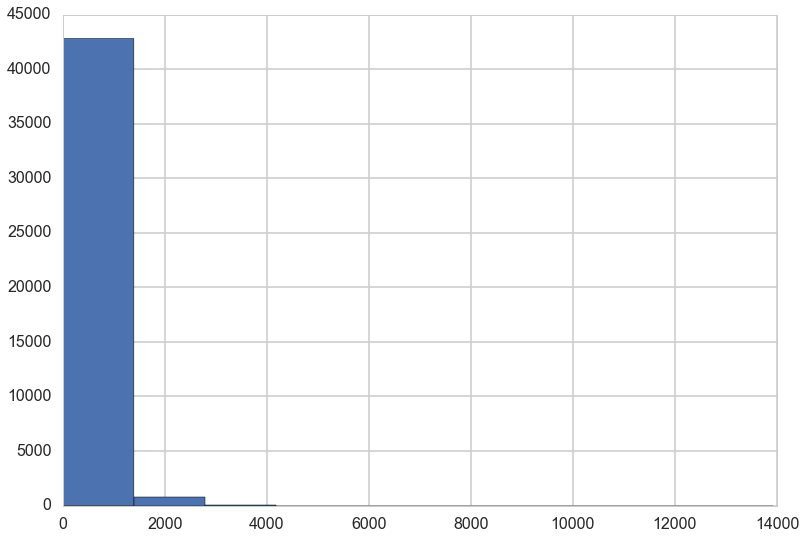

In [22]:
print df.sum_good.describe()
print len(df[df.sum_good == 0]), "are zero"
print len(df[df.sum_good == np.nan]), "are NaN"
df.sum_good.hist()

count    43624.000000
mean       459.943748
std        553.066493
min          0.000000
25%        107.350000
50%        288.945000
75%        621.212500
max      12785.240000
Name: sum_bad, dtype: float64
2258 are zero
0 are NaN


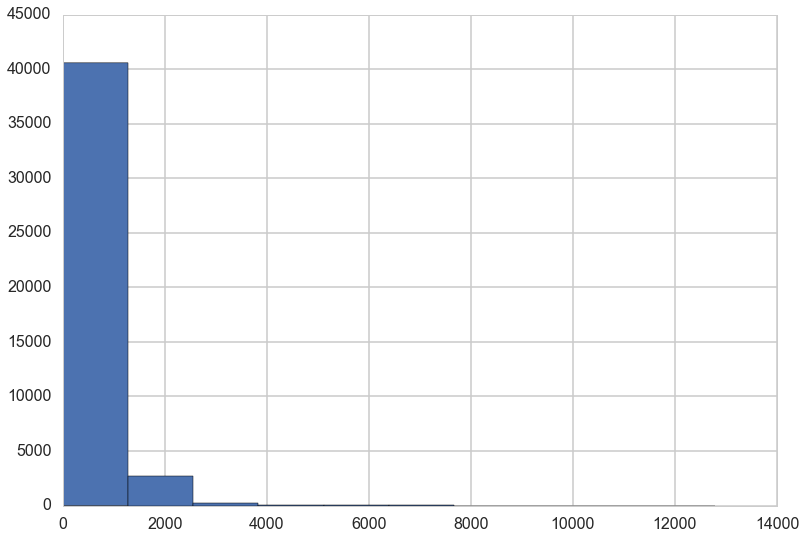

In [23]:
print df.sum_bad.describe()
print len(df[df.sum_bad == 0]), "are zero"
print len(df[df.sum_bad == np.nan]), "are NaN"
df.sum_bad.hist()

In [24]:
df.how_bad.describe()

/home/lucas/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


count    4.295900e+04
mean              inf
std               NaN
min      0.000000e+00
25%               NaN
50%               NaN
75%               NaN
max               inf
Name: how_bad, dtype: float64

In [25]:
df.how_good.describe()

count    4.295900e+04
mean              inf
std               NaN
min      0.000000e+00
25%               NaN
50%               NaN
75%               NaN
max               inf
Name: how_good, dtype: float64

In [26]:
# It looks like I'll have to use
# http://scikit-learn.org/stable/modules/preprocessing.html
# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html
# sklearn.preprocessing.scale(X, axis=0, with_mean=True, with_std=True, copy=True)[source]
# I guess the matrix would be the 24 groups x 45k observations?

In [27]:
# ===============================
# ===== LOGISTIC REGRESSION =====
# ===============================
# ...

In [28]:
# ******************************** THE REST IS TAKEN FROM PREVIOUS EXERCISES ****************************

In [29]:
#dflog=pd.read_csv(data+"01_heights_weights_genders.csv")
#dflog.head()

In [30]:
#your turn
#dflog.plot(x = 'Weight', y= 'Height', kind='scatter') #1st attempt, without colors
#2nd attempt, with colors
#ax = dflog[dflog.Gender == "Male"].plot.scatter(x='Weight', y='Height', color='DarkBlue', label='Male');
#dflog[dflog.Gender == "Female"].plot.scatter(x='Weight', y='Height', color='DarkRed', label='Female', ax=ax);

In [31]:
from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score

def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(y.size, nfold): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [32]:
# First, we try a basic Logistic Regression:
# - Split the data into a training and test (hold-out) set
# - Train on the training set, and test for accuracy on the testing set

from sklearn.cross_validation import train_test_split
Xlr, Xtestlr, ylr, ytestlr = train_test_split(dflog[['Height','Weight']].values, 
                                              (dflog.Gender=="Male").values,random_state=5)

NameError: name 'dflog' is not defined

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(Xlr,ylr)
print accuracy_score(clf.predict(Xtestlr),ytestlr)

In [ ]:
clf = LogisticRegression()
score = cv_score(clf, Xlr, ylr)
print score

In [ ]:
#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]

#your turn
for c in Cs:
    clf = LogisticRegression(C=c)
    clf.fit(Xlr,ylr)
    score = accuracy_score(clf.predict(Xlr),ylr)
    #print "C and score: ", c, score
#print "(select C with maximum score, i.e. C=0.001)"

In [ ]:
#your turn
clf = LogisticRegression(C=0.001)
clf.fit(Xlr, ylr)
accuracy = accuracy_score(clf.predict(Xtestlr), ytestlr)
print(accuracy)

In [ ]:
#your turn
from sklearn import grid_search
clf = grid_search.GridSearchCV(LogisticRegression(C=1), param_grid = {'C':[0.001, 0.1, 1, 10, 100]})
clf.fit(Xlr, ylr)
#print "best parameter:", clf.best_params_
#print "with a score of:", clf.best_score_
#print "From this grid of scores:"
#clf.grid_scores_

#print "Grid scores:"
#for params, mean_score, scores in clf.grid_scores_:
#    print("%0.3f (+/-%0.03f) for %r"
#          % (mean_score, scores.std() * 2, params))
# ??? why *2?

In [ ]:
accuracy = accuracy_score(clf.predict(Xtestlr), ytestlr)
print("Accuracy: %f" % accuracy)

In [ ]:
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print "BEST PARAMS", gs.best_params_
    best = gs.best_estimator_
    return best

In [ ]:
from sklearn.cross_validation import train_test_split
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False, train_size=0.8):
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf = cv_optimize(clf, parameters, Xtrain, ytrain)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    return clf, Xtrain, ytrain, Xtest, ytest

In [ ]:
# DISCUSSION
## MAIN FINDINGS
## LIMITATIONS
## WHAT NEXT